In [5]:
import os
import pickle
import scipy.signal
from scipy import fft
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Data Preprocessing

In [6]:
DATA_PATH = os.path.realpath("../data/WESAD")

In [7]:
class Subject:
    """Subject of the WESAD dataset.
    Subject Class inspired by: https://github.com/WJMatthew/WESAD"""

    def __init__(self, main_path, subject_number):
        self.name = f'S{subject_number}'
        self.subject_keys = ['signal', 'label', 'subject']
        self.signal_keys = ['chest', 'wrist']
        self.chest_keys = ['ACC', 'ECG', 'EMG', 'EDA', 'Temp', 'Resp']
        self.wrist_keys = ['ACC', 'BVP', 'EDA', 'TEMP']
        with open(os.path.join(main_path, self.name) + '/' + self.name + '.pkl', 'rb') as file:
            self.data = pickle.load(file, encoding='latin1')
        self.labels = self.data['label']

    def get_wrist_data(self):
        """Returns data measured by the E4 Empatica"""

        data = self.data['signal']['wrist']
        return data
    
    def get_subject_dataframe(self):
        """Returns a dataframe with the preprocessed data of the subject"""
        wrist_data = self.get_wrist_data()
        bvp_signal = wrist_data['BVP'][:,0]
        eda_signal = wrist_data['EDA'][:,0]
        acc_x_signal = wrist_data['ACC'][:,0]
        acc_y_signal = wrist_data['ACC'][:,1]
        acc_z_signal = wrist_data['ACC'][:,2]
        temp_signal = wrist_data['TEMP'][:,0]
        # Upsampling data to match BVP data sampling rate using fourier method as described in Paper/dataset
        eda_upsampled = scipy.signal.resample(eda_signal, len(bvp_signal))
        temp_upsampled = scipy.signal.resample(temp_signal, len(bvp_signal))
        acc_x_upsampled = scipy.signal.resample(acc_x_signal, len(bvp_signal))
        acc_y_upsampled = scipy.signal.resample(acc_y_signal, len(bvp_signal))
        acc_z_upsampled = scipy.signal.resample(acc_z_signal, len(bvp_signal))
        label_df = pd.DataFrame(self.labels, columns=['label'])
        label_df.index = [(1 / 700) * i for i in range(len(label_df))] # 700 is the sampling rate of the label
        label_df.index = pd.to_datetime(label_df.index, unit='s')
        data_arrays = zip(bvp_signal, eda_upsampled, acc_x_upsampled, acc_y_upsampled, acc_z_upsampled, temp_upsampled)
        df = pd.DataFrame(data=data_arrays, columns=['BVP', 'EDA', 'ACC_x', 'ACC_y', 'ACC_z', 'TEMP'])
        df.index = [(1 / 64) * i for i in range(len(df))] # 64 = sampling rate of BVP
        df.index = pd.to_datetime(df.index, unit='s')
        df = df.join(label_df)
        df['label'] = df['label'].fillna(method='ffill')
        df.reset_index(drop=True, inplace=True)
        df.drop(df[df['label'].isin([0.0, 4.0, 5.0, 6.0, 7.0])].index, inplace=True)
        df['label'] = df['label'].replace([1.0, 2.0, 3.0], [0, 1, 0])
        df.reset_index(drop=True, inplace=True)
        df = (df-df.min())/(df.max()-df.min()) # Normalize data (no train test leakage since data frame per subject) 
        return df


In [8]:
s2 = Subject(DATA_PATH, 2)

In [9]:
s2.get_subject_dataframe()

,BVP,EDA,ACC_x,ACC_y,ACC_z,TEMP,label
0,0.536850,0.993856,0.661565,0.717624,0.545219,0.950902,0.0
1,0.548782,0.995152,0.676264,0.736944,0.507794,0.950913,0.0
2,0.560715,0.996392,0.683334,0.736449,0.507154,0.950923,0.0
3,0.571374,0.997521,0.691702,0.691200,0.545094,0.950932,0.0
4,0.580215,0.998489,0.674626,0.642324,0.583283,0.950940,0.0
...,...,...,...,...,...,...,...
135739,0.533648,0.089840,0.499794,0.927696,0.460655,0.441595,0.0
135740,0.536857,0.089739,0.500468,0.929406,0.464332,0.441532,0.0
135741,0.540788,0.089649,0.503081,0.929464,0.466159,0.441435,0.0
135742,0.544653,0.089569,0.504822,0.929406,0.464332,0.441301,0.0


In [12]:
def create_subjects_data() -> dict:
    # Create a dictionary with all the subjects and belonging dataframes
    subjects = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17]
    subjects_data = {}
    for subject_num in subjects:
        subject = Subject(DATA_PATH, subject_num)
        subjects_data[subject.name] = subject.get_subject_dataframe()

    return subjects_data

### Window

1. Creating the windows
2. Create subwindows from the windows
3. Calculate the fft of the subwindows
4. Average the subwindows

![fft](/Users/nils/master/Stress-Detection-From-Wearables/images/fft.png)

In [13]:
# Subwindow length of the biosignals
signal_subwindow_dict = {
    'ACC_x': 7,
    'ACC_y': 7,
    'ACC_z': 7,
    'BVP': 30,
    'EDA': 30,
    'TEMP': 35
    }

In [14]:
# most frequent element in list
def most_common(lst):
    return max(set(lst), key=lst.count)

In [15]:
def create_windows(df: pd.DataFrame) -> tuple[pd.DataFrame,list]:
    """Creates windows from the dataframe and returns the windows and the labels.
    If the window is assigned to multiple labels, the most common label is chosen for that period.

    Args:
        df (pd.DataFrame): Subject DataFrame

    Returns:
        tuple[pd.DataFrame,list]: Windows representing the activity of the subject in one minute and the corresponding labels.
    """

    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    windows, labels = zip(*[(df[i:i+window_len], int(most_common(df['label'][i:i+window_len].to_list()))) for i in range(0,df.shape[0],window_len)])
    return windows, labels

In [16]:
def create_subwindows(df: pd.DataFrame, signal_subwindow_len: int, signal_name: str) -> list:
    """The function creates subwindows from the windows.

    Args:
        df (pd.DataFrame): Windows representing the activity of the subject in one minute.
        signal_subwindow_len (int): Length of the subwindows.
        signal_name (str): Name of the signal.

    Returns:
        list: Subwindows of the signal in the window.
    """
    subwindow_len = 64 * signal_subwindow_len # fs = 64 and sub-window length in seconds = 30
    window_len = 64 * 60 # fs = 64 and window length in seconds = 60
    window_shift = int(64 * 0.25) # fs = 64 and window shift in seconds = 0.25
    subwindows = []

    for i in range(0, window_len, window_shift):
        if i + subwindow_len <= window_len:
            subwindow = df[signal_name][i:i+subwindow_len]
            subwindows.append(subwindow)
    return subwindows
            

In [17]:
def fft_subwindows(subwindows: list, duration: int, f_s: int) -> list:
    """Calculates the fft of the subwindows.

    Args:
        subwindows (list): C
        duration (int): _description_
        f_s (int): _description_

    Returns:
        list: Fft coefficients of the subwindows.
    """
    freqs= []
    yfs = []
    for subwindow in subwindows:
        y = np.array(subwindow)
        yf = scipy.fft.fft(y)
        l = len(yf)
        N = f_s * duration
        freq = scipy.fft.fftfreq(N, 1/f_s)

        l //= 2
        amps = np.abs(yf[0:l])
        freq = np.abs(freq[0:l])

        # Sort descending amp   
        p = amps.argsort()[::-1]
        freq = freq[p]
        amps = amps[p]

        freqs.append(freq)
        yfs.append(amps)
    return np.asarray(freqs), np.asarray(yfs)
    

In [18]:
def average_window(subwindows_fft: list) -> list:
    """Calculates the average of the fft coefficients of the subwindows.

    Args:
        subwindows_fft (list): List of fft coefficients of the subwindows.

    Returns:
        list: Average of the fft coefficients of the subwindow for signals.
    """
    len_yfs = len(subwindows_fft[0])
    avg_yfs = []
    for i in range(len_yfs):
        i_yfs = []
        for yf in subwindows_fft:
            try:
                i_yfs.append(yf[i])
            except IndexError:
                pass
        avg_yfs.append(sum(i_yfs)/len(i_yfs))
    return avg_yfs

In [19]:
def create_preprocessed_subjects_data(subjects_data: dict) -> dict:
# Creates averaged windows for all subjects from dataframes

    subjects_preprosessed_data = {}
    for subject_name, subject_df in subjects_data.items():
        subjects_preprosessed_data[subject_name] = {}
        windows, labels = create_windows(subject_df)
        yfs_per_min_for_signal = {}
        X = []
        for i in range(0,len(windows) - 1):
            for signal in signal_subwindow_dict.keys():

                duration_in_sec = signal_subwindow_dict[signal]

                subwindows = create_subwindows(windows[i], signal_subwindow_len=duration_in_sec, signal_name=signal)
                freqs, yfs = fft_subwindows(subwindows, duration_in_sec, 64)
                yfs_average = average_window(yfs)[:210]
                yfs_per_min_for_signal[signal] = yfs_average
                
            X.append(pd.DataFrame(yfs_per_min_for_signal).T)
        y = list(labels[:len(windows)-1])
        subjects_preprosessed_data[subject_name]['X'] = X
        subjects_preprosessed_data[subject_name]['y'] = y
    
    return subjects_preprosessed_data


In [ ]:
subjects_data = create_subjects_data()
subjects_preprocessed_data = create_preprocessed_subjects_data(subjects_data)

In [ ]:
subjects_preprocessed_data

In [22]:
def get_subject_window_data(subjects_preprosessed_data: dict) -> tuple[list, list]:
    # Created train and test data for leave one out cross validation
    all_subjects_X = []
    all_subjects_y = []
    for subject_name, subject_data in subjects_preprosessed_data.items():
        all_subjects_X.append(subject_data['X'])
        all_subjects_y.append(subject_data['y'])
    
    return (all_subjects_X, all_subjects_y)


In [23]:
all_subjects_X, all_subjects_y = get_subject_window_data(subjects_preprocessed_data)

![OS_Sensors](/Users/nils/master/Stress-Detection-From-Wearables/images/os_sensors.png)

In [24]:
SMARTWATCH_OS = {
    'E4': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA', 'BVP'],
    'Tizen': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'BVP'],
    'WearOS_watchOS': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP'],
    'Fitbit': ['ACC_x', 'ACC_y', 'ACC_z', 'TEMP', 'EDA'],
    #'PiaOS': ['TEMP', 'EDA', 'BVP']
    }

In [25]:
def filter_for_smartwatch_os(smartwatch_os_name: str, all_subjects_X: list) -> list:
    # Adjusts the data for the smartwatch os
    all_subjects_X_adjusted_for_smartwatch_os = []
    for subject_data in all_subjects_X:
        subject_adjusted_for_smartwatch_os = []
        for window in subject_data:
            subject_adjusted_for_smartwatch_os.append(window.loc[SMARTWATCH_OS[smartwatch_os_name]])
        all_subjects_X_adjusted_for_smartwatch_os.append(subject_adjusted_for_smartwatch_os)
    return all_subjects_X_adjusted_for_smartwatch_os


# Model

In [31]:
#import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

### Build model

![model_architecture](/Users/nils/master/Stress-Detection-From-Wearables/images/model_architecture.png)

In [45]:
def build_model(num_signals: int, num_output_class: int) -> tf.keras.models.Sequential:
    # Define the model architecture
    model = tf.keras.Sequential()
    # input_shape = 14 Signale (bei uns max. 6) X 210 Inputs (aus Tabelle nach Fourier)
    model.add(tf.keras.layers.InputLayer(input_shape=[num_signals, 210, 1]))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same')) 
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Conv2D(filters=64, activation='relu', kernel_size=(1,3), strides=1, padding='same'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(1,2)))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=128, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    model.add(tf.keras.layers.Dense(units=64, activation='relu', kernel_initializer='glorot_uniform'))
    model.add(tf.keras.layers.Dropout(rate=0.3))
    # Anzahl der Units = Anzahl der Klassen (2 - non-stress vs stress)
    model.add(tf.keras.layers.Dense(units=num_output_class, activation='sigmoid')) # sigmoid statt softmax, da nur 2 Klassen

    model.compile(optimizer="rmsprop",loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
    return model

### Train model

In [ ]:
for os, signals in SMARTWATCH_OS.items():
    print(f'\n\n\nSmartwatchOS: {os} - Signals: {signals} - Num. Signals: {len(signals)}')
    print(f'Number of signals: {len(signals)}')
    all_subjects_X_os = filter_for_smartwatch_os(os, all_subjects_X)

    groups_set = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    subject_ids = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17] # ids for subjects in WESAD dataset
    num_signals = len(signals) # Number of signals in the WESAD dataset measured by the empatica e4
    num_output_class = 2 # Number of output classes (2 - non-stress vs stress)
    num_epochs = 100

    all_acc_histories = []
    all_loss_histories = []

    for i in groups_set:
        test_index = groups_set[i]
        train_index = [x for x in groups_set if x != test_index]
        print(train_index, test_index)

        X_train = np.concatenate(np.array([all_subjects_X_os[x] for x in train_index], dtype=object))
        y_train = np.concatenate(np.array([all_subjects_y[y] for y in train_index], dtype=object))
        X_test = all_subjects_X_os[test_index]
        y_test = all_subjects_y[test_index]
        
        weight_balance = y_train.tolist().count(0)/y_train.tolist().count(1)

        X_train = np.asarray(X_train)
        X_test = np.asarray(X_test)
        y_train = np.asarray(y_train)
        y_test = np.asarray(y_test)

        y_train = tf.keras.utils.to_categorical(y_train, num_output_class)
        y_test = tf.keras.utils.to_categorical(y_test, num_output_class)

        tf.keras.backend.clear_session()

        model = build_model(num_signals, num_output_class)

        checkpoint = tf.keras.callbacks.ModelCheckpoint(
            f"models/{os}/wesad_{os}_binary_s{subject_ids[test_index]}_{num_epochs}.h5",  # Path to save the model file
            monitor="loss", # The metric name to monitor
            save_best_only=True # If True, it only saves the "best" model according to the quantity monitored 
        )
        
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor="loss",     # Quantity to be monitored.
            min_delta=0.001,     # Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
            patience=100,        # Number of epochs with no improvement after which training will be stopped.
        )

        history = model.fit(
        X_train, 
        y_train,
        epochs=num_epochs, 
        batch_size=50,
        verbose=1,
        class_weight={0: 1, 1: weight_balance}, # to address the imbalance of the class labels
        callbacks = [checkpoint, early_stopping]
    )   
    

# Evaluation

Evaluating every models on the corresponding test dataset not seen during training.

In [47]:
model.evaluate(X_test, y_test, verbose=0, )

[0.5121550559997559,
 0.7567567825317383,
 0.7631579041481018,
 0.7837837934494019]

In [48]:
# Evaluating every models on the corresponding test dataset not seen during training.
os_scores_acc = {}
os_scores_f1 = {}

for os, signals in SMARTWATCH_OS.items():

    all_subjects_X_os = filter_for_smartwatch_os(os, all_subjects_X)

    all_accuracies = []
    all_precisions = []
    all_recalls = []
    all_f1s = []

    for i, subject_id in enumerate(subject_ids):
        X_test = all_subjects_X_os[i]
        y_test = all_subjects_y[i]
        X_test = np.asarray(X_test)
        y_test = np.asarray(y_test)
        
        y_test = tf.keras.utils.to_categorical(y_test, num_output_class)
        
        model_path = f'models/{os}/wesad_{os}_binary_s{subject_id}_{num_epochs}.h5'

        model = tf.keras.models.load_model(model_path)
        accuracy = model.evaluate(X_test, y_test, verbose=0, )[1]
        precision = model.evaluate(X_test, y_test, verbose=0, )[2]
        recall = model.evaluate(X_test, y_test, verbose=0, )[3]
        f1 = 2 * precision * recall / (precision + recall)
        all_accuracies.append(accuracy)
        all_precisions.append(precision)
        all_recalls.append(recall)
        all_f1s.append(f1)

    print(f'Smartwatch OS: {os}')
    print(f'Evaluation of CNN model trained on {num_epochs} epochs\n')
    print(f'Subject\t\t Accuracy\tPrecision\tRecall\t\tF1-Score')
    print("************************************************************************")
    for i in range(len(all_accuracies)):
        print(f'S{subject_ids[i]}\t\t {round(all_accuracies[i], 5):.5f}\t{round(all_precisions[i], 5):.5f}\t\t{round(all_recalls[i], 5):.5f}\t\t{round(all_f1s[i], 5):.5f}')

    print("************************************************************************")
    print(f'Average\t\t {round(np.mean(all_accuracies), 5):.5f}\t{round(np.mean(all_precisions), 5):.5f}\t\t{round(np.mean(all_recalls), 5):.5f}\t\t{round(np.mean(all_f1s), 5):.5f}\n\n\n')

    os_scores_acc[os] = all_accuracies
    os_scores_f1[os] = all_f1s


Smartwatch OS: E4
Evaluation of CNN model trained on 100 epochs

Subject		 Accuracy	Precision	Recall		F1-Score
************************************************************************
S2		 0.85714	0.85714		0.85714		0.85714
S3		 0.68571	0.66667		0.68571		0.67606
S4		 1.00000	1.00000		1.00000		1.00000
S5		 0.94444	0.94444		0.94444		0.94444
S6		 0.97222	0.94595		0.97222		0.95890
S7		 0.97222	0.97222		0.97222		0.97222
S8		 0.97222	0.97222		0.97222		0.97222
S9		 0.94444	0.94444		0.94444		0.94444
S10		 0.97297	0.97297		0.97297		0.97297
S11		 0.70270	0.70270		0.70270		0.70270
S13		 1.00000	1.00000		1.00000		1.00000
S14		 0.21622	0.21622		0.21622		0.21622
S15		 0.89189	0.91667		0.89189		0.90411
S16		 1.00000	1.00000		1.00000		1.00000
S17		 0.86486	0.86486		0.86486		0.86486
************************************************************************
Average		 0.86647	0.86510		0.86647		0.86575



Smartwatch OS: Tizen
Evaluation of CNN model trained on 100 epochs

Subject		 Accuracy	Precision	Recall	

In [49]:
df_os_scores_acc = pd.DataFrame(os_scores_acc)
replacements = {l1:f'S{l2}' for l1, l2 in zip(groups_set, subject_ids)}
df_os_scores_acc = df_os_scores_acc.rename(replacements)
df_os_scores_acc.to_csv('os_scores_acc.csv')

In [50]:
df_os_scores_f1 = pd.DataFrame(os_scores_f1)
replacements = {l1:f'S{l2}' for l1, l2 in zip(groups_set, subject_ids)}
df_os_scores_f1 = df_os_scores_f1.rename(replacements)
df_os_scores_f1.to_csv('os_scores_f1.csv')

<AxesSubplot:title={'center':'Accuracy of different os models on each subject'}>

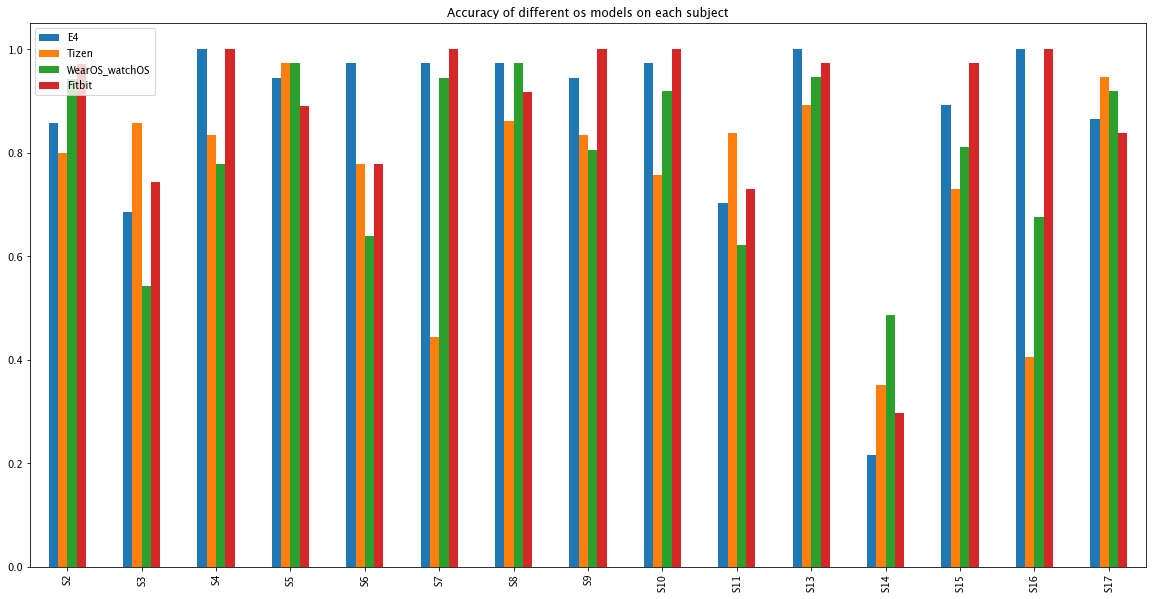

In [51]:
df_os_scores_acc.plot.bar(figsize=(20,10), title='Accuracy of different os models on each subject')

<AxesSubplot:title={'center':'F1-Score of different os models on each subject'}>

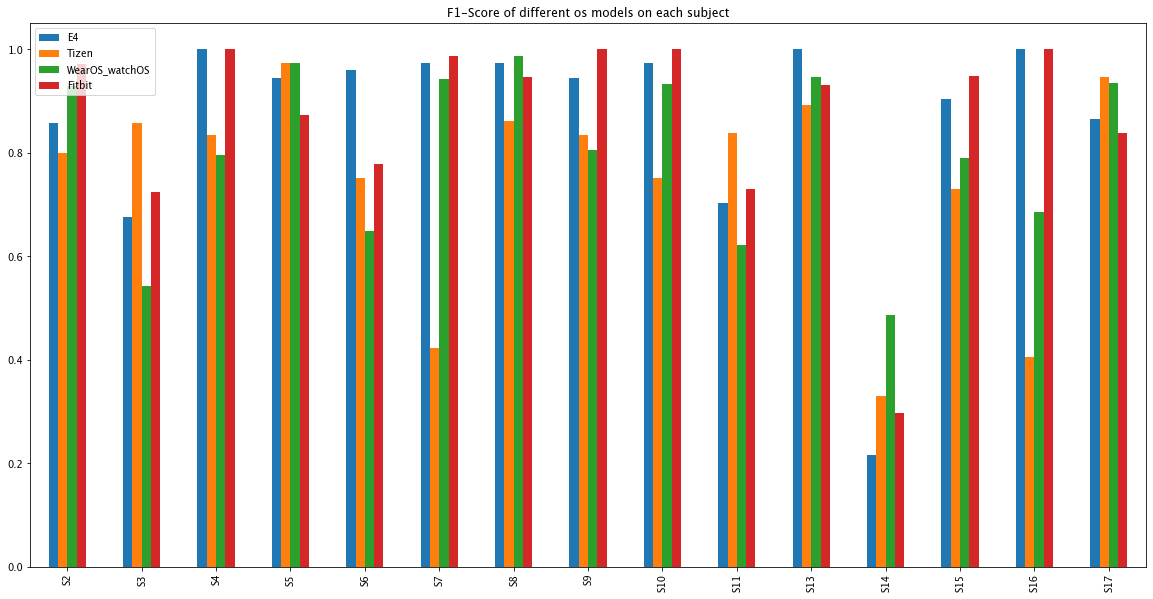

In [52]:
df_os_scores_f1.plot.bar(figsize=(20,10), title='F1-Score of different os models on each subject')

           E4     Tizen  WearOS_watchOS    Fitbit
S2   0.857143  0.800000        0.942857  0.971429
S3   0.685714  0.857143        0.542857  0.742857
S4   1.000000  0.833333        0.777778  1.000000
S5   0.944444  0.972222        0.972222  0.888889
S6   0.972222  0.777778        0.638889  0.777778
S7   0.972222  0.444444        0.944444  1.000000
S8   0.972222  0.861111        0.972222  0.916667
S9   0.944444  0.833333        0.805556  1.000000
S10  0.972973  0.756757        0.918919  1.000000
S11  0.702703  0.837838        0.621622  0.729730
S13  1.000000  0.891892        0.945946  0.972973
S14  0.216216  0.351351        0.486486  0.297297
S15  0.891892  0.729730        0.810811  0.972973
S16  1.000000  0.405405        0.675676  1.000000
S17  0.864865  0.945946        0.918919  0.837838

E4                0.866471
Tizen             0.753219
WearOS_watchOS    0.798347
Fitbit            0.873895
dtype: float64



Text(0.5, 1.0, 'Average accuracy of different models on each OS')

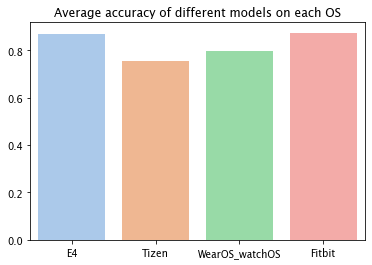

In [53]:
# bar plot of the accuracy of the different loso models
print(f'{df_os_scores_acc}\n')
print(f'{df_os_scores_acc.mean()}\n')
sns.barplot(x=df_os_scores_acc.keys(), y=df_os_scores_acc.mean(), palette='pastel').set_title(label='Average accuracy of different models on each OS')

           E4     Tizen  WearOS_watchOS    Fitbit
S2   0.857143  0.800000        0.927536  0.971429
S3   0.676056  0.857143        0.542857  0.724638
S4   1.000000  0.833333        0.794521  1.000000
S5   0.944444  0.972222        0.972222  0.873239
S6   0.958904  0.750000        0.647887  0.777778
S7   0.972222  0.422535        0.942857  0.986301
S8   0.972222  0.861111        0.985915  0.945946
S9   0.944444  0.833333        0.805556  1.000000
S10  0.972973  0.750000        0.931507  1.000000
S11  0.702703  0.837838        0.621622  0.729730
S13  1.000000  0.891892        0.945946  0.929577
S14  0.216216  0.328767        0.486486  0.297297
S15  0.904110  0.729730        0.789474  0.947368
S16  1.000000  0.405405        0.684932  1.000000
S17  0.864865  0.945946        0.933333  0.837838

E4                0.865754
Tizen             0.747950
WearOS_watchOS    0.800843
Fitbit            0.868076
dtype: float64



Text(0.5, 1.0, 'F1 score of different models on each OS')

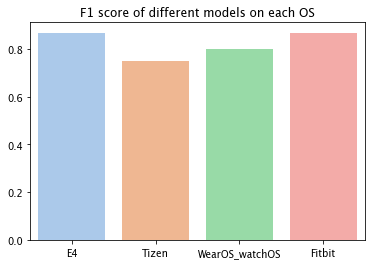

In [54]:
# bar plot of the accuracy of the different loso models
print(f'{df_os_scores_f1}\n')
print(f'{df_os_scores_f1.mean()}\n')
sns.barplot(x=df_os_scores_f1.keys(), y=df_os_scores_f1.mean(), palette='pastel').set_title(label='F1 score of different models on each OS')

# Prediction

In [55]:
model_path = "./models/Fitbit/wesad_Fitbit_binary_s3_100.h5"
model = tf.keras.models.load_model(model_path)
predictions = model.predict(X_test) # make predictions on the test set using the trained model
pred_class = np.argmax(predictions, axis=-1) # get the class with the highest probability

In [56]:
true_classified = 0
for i in range(len(pred_class)):
    print("Prediction: ", predictions[i])
    print("Prediction: ", pred_class[i])
    ground_truth = max(enumerate(y_test[i]),key=lambda x: x[1])[0]
    print("Ground Truth: ", ground_truth)
    print()
    if ground_truth == pred_class[i]:
        true_classified += 1
print("Accuracy: ", true_classified/len(pred_class))
    

Prediction:  [0.39155424 0.6268184 ]
Prediction:  1
Ground Truth:  0

Prediction:  [0.3796326  0.61021686]
Prediction:  1
Ground Truth:  0

Prediction:  [0.6312174 0.3352824]
Prediction:  0
Ground Truth:  0

Prediction:  [0.7924833  0.24528879]
Prediction:  0
Ground Truth:  0

Prediction:  [0.4392612 0.5476617]
Prediction:  1
Ground Truth:  0

Prediction:  [9.9997437e-01 7.4189906e-05]
Prediction:  0
Ground Truth:  0

Prediction:  [0.99805576 0.00189915]
Prediction:  0
Ground Truth:  0

Prediction:  [0.97802615 0.01607677]
Prediction:  0
Ground Truth:  0

Prediction:  [0.74056965 0.17411408]
Prediction:  0
Ground Truth:  0

Prediction:  [0.69090605 0.31151506]
Prediction:  0
Ground Truth:  0

Prediction:  [0.806082  0.2004379]
Prediction:  0
Ground Truth:  0

Prediction:  [0.9855296  0.01166433]
Prediction:  0
Ground Truth:  0

Prediction:  [0.8224094  0.13898557]
Prediction:  0
Ground Truth:  0

Prediction:  [0.5435084  0.42945445]
Prediction:  0
Ground Truth:  0

Prediction:  [0.9638